In [ ]:
          ###################       PCA - PRINICPAL COMPONENT ANALYSIS AND ###################
          ##################        APPLICATION OF PCA IN PAIR TRADING     ###################


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib
from itertools import groupby, count
import pickle
%matplotlib inline

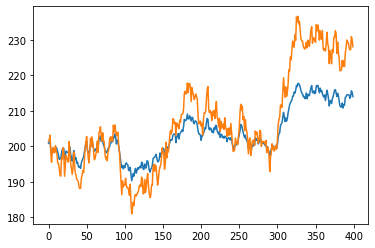

In [48]:
# Create a random seed for consistency

np.random.seed(20)

# Produce a series as the cumulative sum of normally distributed random numbers.

x = np.cumsum(np.random.randn(400)) + 200

# Produce a second series with the same behaviour but higher standard deviation.

y = x*2 + np.random.randn(400) - 200

# Generate an array to be used in our PCA calculation.

# Note that we have to de-mean our values first.

R = np.array([x-np.mean(x),y-np.mean(y)])

# Plot x and y

plt.plot(x)
plt.plot(y)

In [49]:
# NOW WE SHOUDL Calculate the covariance matrix  ####################
S = np.cov(R)

print('Cov Matrix:', S)

# and WE SHOULD Calculate the eigenvalues and eigenvectors  ##############


EIG = np.linalg.eig(S)
print('Eigenvalues: ',EIG[0])
print('Eigenvectors: ',EIG[1])

Cov Matrix: [[ 46.61197617  93.00600641]
 [ 93.00600641 186.48398365]]
Eigenvalues:  [1.81481951e-01 2.32914478e+02]
Eigenvectors:  [[-0.89470603 -0.44665549]
 [ 0.44665549 -0.89470603]]


In [51]:
# Extract the eigenvectors from EIG

EV = EIG[1]


# Create x-values for plotting eigenvectors   #######################

xx = np.linspace(min(R[0,:]),max(R[0,:]),200)

# Create y-values for plotting eigenvectors  ############################

yy1 = (EV[1][0]/EV[0][0])*xx
yy2 = (EV[1][1]/EV[0][1])*xx



#####     The most significant eigenvector is the one with the highest eigenvalue. Here we extract its row number. ######



In [52]:
most_significant_factor = np.argmax(EIG[0])
print('Most significant factor: ',most_significant_factor)


Most significant factor:  1


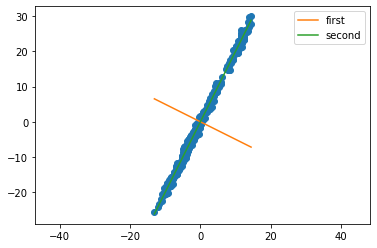

In [53]:
# Plot de-meaned x - y correlation  ######


plt.plot(R[0,:],R[1,:],'o')


# Plot the first principal component   #######

plt.plot(xx,yy1,label='first')

# Plot the second principal component  ######

plt.plot(xx,yy2,label='second')
plt.legend()


# Make sure axis are equal to illustrate orthogonality  ######
plt.axis('equal');

In [54]:
# Calculating the factor values from the eigenvector  ###############

factors = np.dot(EV.T,R)


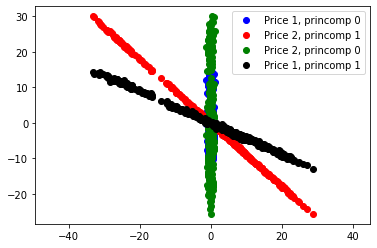

In [55]:
# NOW WE'LL SEE Correlations between factors

plt.plot(factors[0],R[0,:],'bo',label='Price 1, princomp 0')
plt.plot(factors[1],R[1,:],'ro',label='Price 2, princomp 1')
plt.plot(factors[0],R[1,:],'go',label='Price 2, princomp 0')
plt.plot(factors[1],R[0,:],'ko',label='Price 1, princomp 1')
plt.axis('equal')
plt.legend();


In [62]:
################################    APPLICATION OF PCA IN PAIR TRADING  ######################

def make_coint_0(N,T0=[0,0],sigma=[1,1],c=[0.1,0.1]):
    
    X = [0]
    Y = [0]
    for i in range(N):
        rx = np.random.randn()*sigma[0] - c[0]*(X[-1] - Y[-1])
        ry = np.random.randn()*sigma[1] + c[1]*(X[-1] - Y[-1])
        X.append(X[-1]+rx)
        Y.append(Y[-1]+ry)
    return np.array(X)+T0[0],np.array(Y)+T0[1]

##### ALGORİTHM FORM = RESEARCHGATE.NET







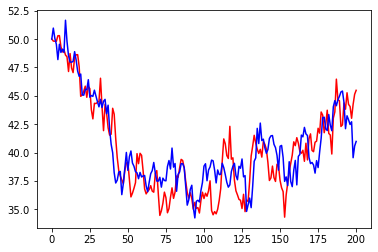

In [63]:
np.random.seed(452)
X,Y = make_coint_0(200,T0=[50,50],c=[0.1,0.1])
plt.plot(X,'r-',Y,'b-');



###Assessing the quality of our cointegration:
##Critical values for 0.1, 0.05 and 0.01.
### T-statistic should be below crit.


In [64]:
crit = coint(X,Y)
print('Critical Values:',crit[2])
print('T-statistic:',crit[0])
print('P-value:',crit[1])


Critical Values: [-3.95203768 -3.36685108 -3.065724  ]
T-statistic: -5.574176718429721
P-value: 1.2687688654668363e-05


In [66]:
##################                  PCA Trade   ###################

def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))
def run_pca(pr,components=1,log_prices=True):
    
    #1 Instanciate PCA
    
    pca = PCA(n_components=components)
    px = pr.T-np.mean(pr.T)
    
    if log_prices:
        #2 WE SHOULD Calculate the priciple components using log prices
        
        
        comps = pca.fit(np.log(pr.T)).components_.T
        #3 NOW,Create the factors from the pricinple components
        
        factors = sm.add_constant(pr.T.dot(comps))
    else:
        # Calculate the N priciple components using normal prices
        
        comps = pca.fit(px).components_.T
        
        # Create the factors from the pricinple components
        
        
        factors = sm.add_constant(px.dot(comps))
    
    # Regress each factor with the actual underlying prices
    
    mm = [sm.OLS(s.T, factors).fit() for s in pr]
    
    # Calculate the residuals
    
    resids = list(map(lambda x: x.resid, mm))
    return resids, factors




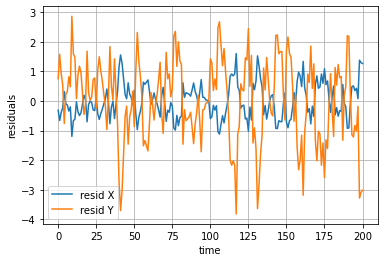

In [68]:
# Create input array from cointegrated price series


R = np.array([X,Y,X])


# Run the PCA calculation


residuals, factors = run_pca(R,log_prices=True)

# NOW FİNALLY, Plot the residuals

plt.plot(residuals[0],label='resid X')
plt.plot(residuals[1],label='resid Y')
plt.xlabel('time')
plt.ylabel('residuals')
plt.legend()
plt.grid()

##       WE CAN SEE THAT As a side-node, observe that linear regression is not reversible.



In [69]:
m = np.polyfit(X,Y,1)[0]

m_rev = np.polyfit(Y,X,1)[0]


print('Slope of regression:',m)

print('Inverse slope of reverse regression:',1/m_rev)


 ### We enter our last command to see slope of regression and inverse slope of regression and we have observations.

Slope of regression: 0.7978929779688265
Inverse slope of reverse regression: 1.0528140853084136


In [ ]:
''''''''''''''''''''''
##################  Let's examine how we do this analysis and its steps.#########################


Principal component analysis (PCA) is a statistical technique used to reduce the dimensionality of a data set. 
It does this by transforming the data into a new set of variables, called principal components, which are uncorrelated, 
and represent the most important underlying structure of the data. PCA is used in tasks such as data compression and feature 
extraction, which can be used for applications such as classification, clustering, and regression. 
PCA is also used in exploratory data analysis to help identify trends and patterns in the data.

                                   PART 1
- Create an algorithm 
- T = starting values
-Sigma = standard deviations
- C = correlation between both returns
-if c[0] = 0 and c[1] = 0 -> both are random walks
-if one c is zero and the other non-zero there is a one way causality
-if both c are non-zero there is two-way causality.


                                    PART 2
    
- Sklearn package - To generate the components of PCA.
- Linear regression run on price data of Stocks/ commodities/ Index.
- Z-score calculation ( residual to normalize for price levels and volatility)
- Trade condition - Residual deviates from the mean
-Using log prices to mitigate big price swings.

''''''''''''''''''''''

               
                                        AHMET MAHMUT GÖKKAYA 

